In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


In [3]:
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset' 
classes = [i for i in os.listdir(fish_dir) if '.' not in i]                    
classes

['Hourse Mackerel',
 'Black Sea Sprat',
 'Sea Bass',
 'Red Mullet',
 'Trout',
 'Striped Red Mullet',
 'Shrimp',
 'Gilt-Head Bream',
 'Red Sea Bream']

In [4]:
label = []
path = []

for dir_name, _,filenames in os.walk(fish_dir):                    
    for filename in filenames:                                 
        if os.path.splitext(filename)[-1]=='.png':               # If filename contains .png
            if dir_name.split()[-1]!='GT':                       # If directory doesn't contain GT
                label.append(os.path.split(dir_name)[-1])         # Append the directory name to label 
                path.append(os.path.join(dir_name,filename))     # Append all the png files to path of that directory

data = pd.DataFrame(columns=['path','label'])
data['path']=path
data['label']=label

In [5]:
data['label'].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

In [6]:
batch_size = 32
img_height = 224
img_width = 224

In [7]:
# Prepare data generators with rescaling and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2, # 20% data for validation
    fill_mode='nearest')  # Dönüşüm sonrası doldurma yöntemi

In [8]:
train_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    directory=fish_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical')

Found 14400 images belonging to 9 classes.
Found 3600 images belonging to 9 classes.


In [9]:
# Get the number of classes
num_classes = len(train_generator.class_indices)

In [10]:
# Build the ANN model
model_ann = keras.Sequential([
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    layers.Flatten(),  # 3D görüntüyü 1D vektöre çevirir
    layers.Dense(512, activation='relu'),# 512 nöronlu tam bağlantılı katman
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.6),  # Aşırı öğrenmeyi engellemek için dropout
    layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model_ann.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'])

# Print model summary
model_ann.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,236,745 (294.63 MB)

 Trainable params: 77,236,489 (294.63 MB)

 Non-trainable params: 256 (1.00 KB)

In [11]:
# Train the model
with tf.device('/GPU:0'):
    history = model_ann.fit(
        train_generator,
        epochs=10,
        validation_data=validation_generator)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


450/450 ━━━━━━━━━━━━━━━━━━━━ 513s 1s/step - accuracy: 0.2135 - loss: 2.2846 - val_accuracy: 0.2589 - val_loss: 2.0081
Epoch 2/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 517s 1s/step - accuracy: 0.4144 - loss: 1.5638 - val_accuracy: 0.2717 - val_loss: 1.9611
Epoch 3/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 555s 1s/step - accuracy: 0.4849 - loss: 1.3722 - val_accuracy: 0.5978 - val_loss: 1.1828
Epoch 4/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 520s 1s/step - accuracy: 0.5297 - loss: 1.2852 - val_accuracy: 0.5000 - val_loss: 1.4384
Epoch 5/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 479s 1s/step - accuracy: 0.5857 - loss: 1.1451 - val_accuracy: 0.5569 - val_loss: 1.2424
Epoch 6/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 488s 1s/step - accuracy: 0.6539 - loss: 0.9769 - val_accuracy: 0.5289 - val_loss: 1.4368
Epoch 7/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 519s 1s/step - accuracy: 0.6751 - loss: 0.9205 - val_accuracy: 0.5581 - val_loss: 1.2006
Epoch 8/10
450/450 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.7206 - loss: 0.8135 - val_accuracy: 0.600

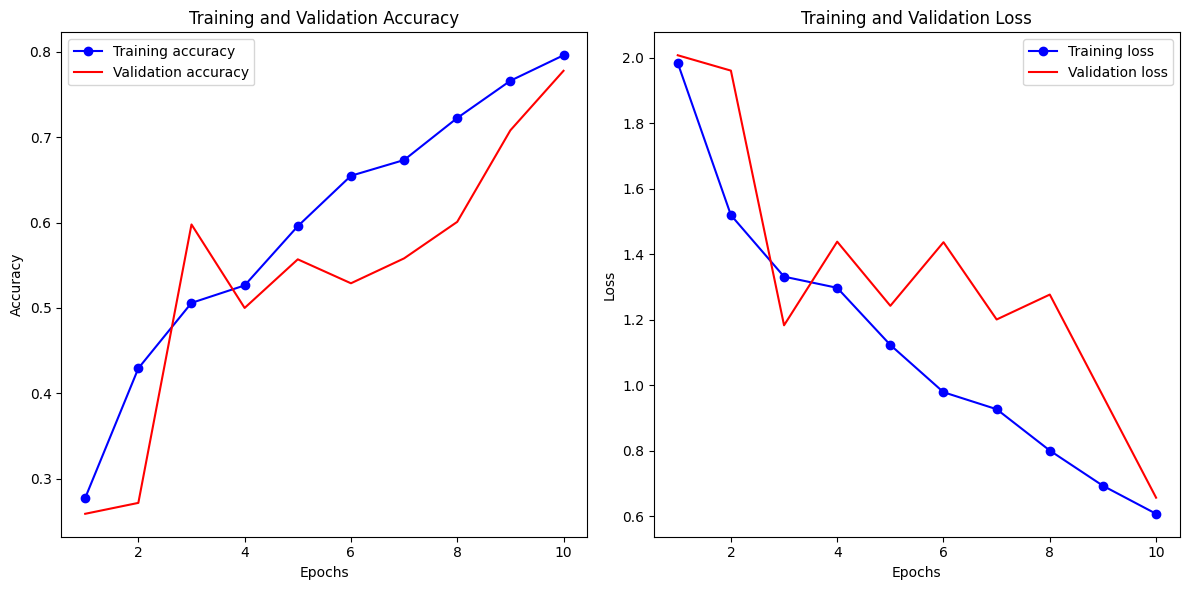

In [12]:
import matplotlib.pyplot as plt

# Eğitim ve doğrulama için accuracy (doğruluk) verileri
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Eğitim ve doğrulama için loss (kayıp) verileri
loss = history.history['loss']
val_loss = history.history['val_loss']

# Epoch sayısı
epochs = range(1, len(accuracy) + 1)

# Accuracy grafiği
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Grafikleri göster
plt.tight_layout()
plt.show()
